In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
mp.rcParams['figure.figsize'] = [12.0, 8.0]

# Data
preloaded and filtered start cluster in Gaia data release 1

In [3]:
ls data

gdr1set01.csv  gdr1set02.csv  gdr1set03.csv  gdr1set04.csv


In [4]:
d = pd.read_csv("data/gdr1set03.csv")

In [5]:
d[:10]

,ra,dec,parallax,parallax_error,pmra,pmdec
0,55.879796,22.158187,7.418107,0.240476,19.719670,-45.481206
1,54.637015,21.284088,9.081912,0.388545,20.792591,-44.517357
2,57.588858,23.096158,7.200001,0.605311,20.868535,-46.429938
3,56.613754,24.254813,7.743384,0.322796,19.955615,-44.291813
4,56.046827,23.379132,7.998248,0.295432,22.119289,-46.981271
5,56.851815,23.914490,7.648681,0.304244,18.854205,-43.756975
6,58.370320,20.907178,7.484718,0.247357,19.415576,-44.615109
7,56.791982,24.276466,7.146140,0.429940,20.432344,-43.945524
8,57.300869,23.886600,7.836103,0.293032,19.403250,-44.934906
9,56.837754,24.116080,7.876296,0.458199,20.889324,-44.683971


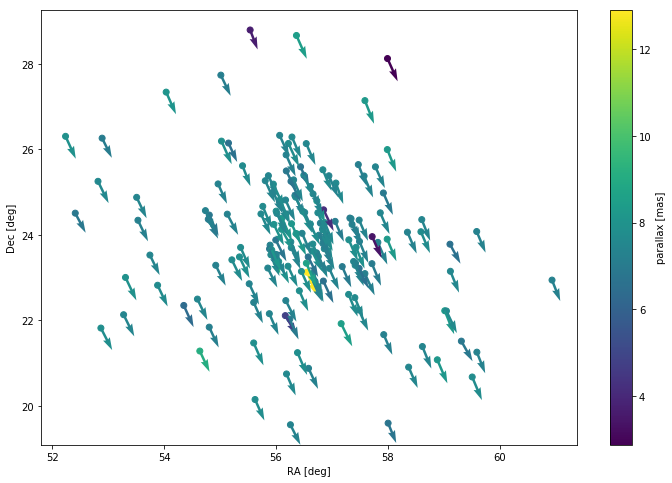

In [6]:
plt.scatter(d.ra,d.dec,c=d.parallax)
plt.quiver(d.ra,d.dec,d.pmra,d.pmdec,d.parallax)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.colorbar(label="parallax [mas]")

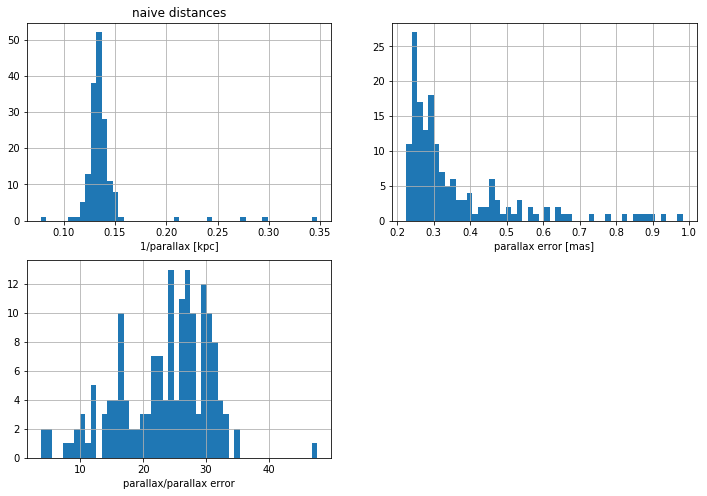

In [7]:
plt.subplot(221)
plt.hist(1/d.parallax,bins=50)
plt.title("naive distances")
plt.xlabel("1/parallax [kpc]")
plt.grid()

plt.subplot(222)
d.parallax_error.hist(bins=50)
plt.xlabel("parallax error [mas]")

plt.subplot(223)
plt.hist(d.parallax/d.parallax_error,bins=50)
plt.xlabel("parallax/parallax error")
plt.grid()

# Naive approach

In [8]:
d['naive'] = 1/d.parallax

In [9]:
d.describe()

,ra,dec,parallax,parallax_error,pmra,pmdec,naive
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,56.450142,23.915943,7.420620,0.360862,20.310049,-45.363689,0.137662
std,1.437846,1.597308,0.897206,0.158987,1.616089,1.905962,0.026863
min,52.236363,19.559188,2.876983,0.224417,15.722158,-50.403756,0.077495
25%,55.890921,23.123783,7.228126,0.256542,19.350445,-46.386956,0.129681
50%,56.459364,23.908128,7.446194,0.296376,20.177419,-45.337092,0.134297
75%,57.325254,24.801697,7.711214,0.403048,21.273851,-44.308194,0.138348
max,60.934125,28.796775,12.904005,0.982605,25.616620,-40.565519,0.347586


Take inverse of mean of parallaxes and estimate variance by first order Taylor expansion

In [10]:
mpar = d.parallax.mean()
rNaive1 = 1/mpar
rNaive1SD = np.linalg.norm(d.parallax_error,2)/len(d)/ mpar**2
print("Inverse of mean parallaxes: ",rNaive1,"+/-",rNaive1SD," kpc")
print("SD of inverse mean parallax in the sense of spread:", d.parallax_error.std()/mpar**2, "kpc")

Inverse of mean parallaxes:  0.1347596266015168 +/- 0.000558913743742  kpc
SD of inverse mean parallax in the sense of spread: 0.002887233947677139 kpc


 Take inverse of variance weighted mean of parallaxes 
 and again estimate variance by first order Taylor expansion

In [11]:
wfac = np.sum(1/d.parallax_error**2)
wmpar = np.sum(d.parallax/d.parallax_error**2)/wfac
rNaive2 = 1/wmpar
rNaive2SD = 1/(wmpar**2 * np.sqrt(wfac))
print("Inverse of weighted mean of parallaxes: ", rNaive2, "+/-", rNaive2SD, "kpc")

Inverse of weighted mean of parallaxes:  0.13370661574389148 +/- 0.000428167046609 kpc


# Simple estimate of the cluster distance 
(no correlation or cluster spread)

We assume that each parallax is an independent estimate of the parallax of the cluster
- no correlations between parallax measurements,
- no intrinsic spread in stellar parallaxes.

## multivariate normal function from scipy

multivariate normal distribution :
* dimension $k$
* mean $\mu$
* covariance $\Sigma$
$$f(x) =  \frac{1}{\sqrt{(2 \pi)^k  |\Sigma| } }\exp{-\frac{1}{2}(x-\mu)' \Sigma^{-1} (x-\mu)}$$

In [12]:
from scipy.stats import multivariate_normal

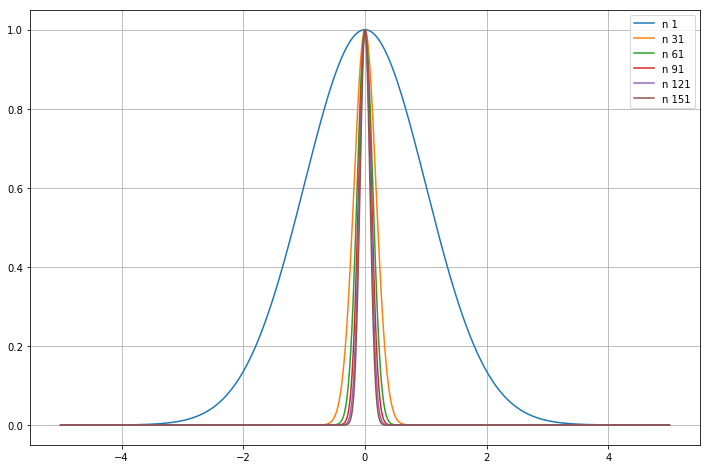

In [13]:
for n in np.arange(1,160,30):
    mn2 = multivariate_normal(mean=np.zeros(n), cov=np.diag(np.ones(n)))
    x = np.linspace(-5,5,1000)
    y = mn2.pdf(np.outer(x,np.ones(n)))/mn2.pdf(np.zeros(n))
    plt.plot(x,y,label="n %s"%n)
plt.grid()
plt.legend()

## Likelihood

In [14]:
model = np.linspace(0.13, 0.14, 1000)

In [15]:
test = np.outer(model,np.ones(164))

In [16]:
test[0][:10]

array([ 0.13,  0.13,  0.13,  0.13,  0.13,  0.13,  0.13,  0.13,  0.13,  0.13])

In [17]:
d.parallax_error.mean()**2

0.13022108217870165

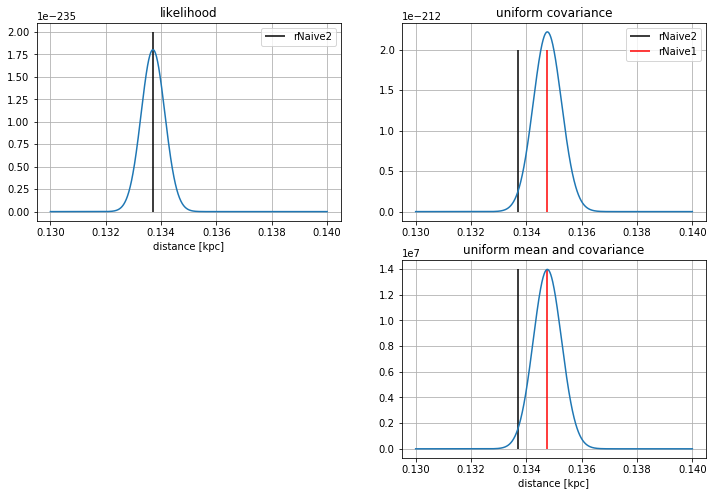

In [18]:
plt.subplot(221)
plt.plot(model, multivariate_normal(mean=d.parallax, cov=np.diag(d.parallax_error**2)).pdf(1/test))
plt.title("likelihood")
plt.vlines(rNaive2,0,2e-235,label="rNaive2")
plt.grid()
plt.legend()
plt.xlabel("distance [kpc]")

plt.subplot(222)
plt.plot(model,multivariate_normal.pdf(1/test,mean=d.parallax,cov=d.parallax_error.mean()**2) )
plt.title("uniform covariance")
plt.vlines(rNaive2,0,2e-212,label="rNaive2")
plt.vlines(rNaive1,0,2e-212,label="rNaive1",color='r')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(model,multivariate_normal.pdf(1/test,mean=d.parallax.mean()*np.ones(164),cov=d.parallax_error.mean()**2) )
plt.title("uniform mean and covariance")
plt.xlabel("distance [kpc]")
plt.grid()
plt.vlines(rNaive2,0,1.4e7,label="rNaive2")
plt.vlines(rNaive1,0,1.4e7,label="rNaive1",color='r')

multivariate normal mode (if one wants to normalise to maximum=1)

In [19]:
1/np.sqrt(np.linalg.det(np.diag(d.parallax_error**2))*(2*np.pi)**164)

1495244879129.0234

In [20]:
1/np.sqrt(np.linalg.det(np.diag(np.ones(164)*d.parallax_error.mean()**2))*(2*np.pi)**164)

13976041.521202946

In [21]:
def likelihood(model,data) :
    parallaxes, parallaxesCov = data
    f = multivariate_normal(mean=parallaxes, cov=parallaxesCov) 
    distance = np.array(model)
    return f.pdf(np.outer(1/distance,np.ones(len(parallaxes))) )

In [22]:
data = d.parallax, np.diag(d.parallax_error**2)

In [23]:
likelihood(0.13,data)

1.098834176933208e-252

In [24]:
likelihood([0.13,0.14],data)

array([  1.09883418e-252,   2.91987080e-278])

## prior

In [25]:
rlen = 1

In [26]:
def distPrior(model):
    """non normalized distance prior"""
    d = np.array(model)
    res = np.exp(-d/rlen) * d**2
    res[d<=0] = 0
    return  res

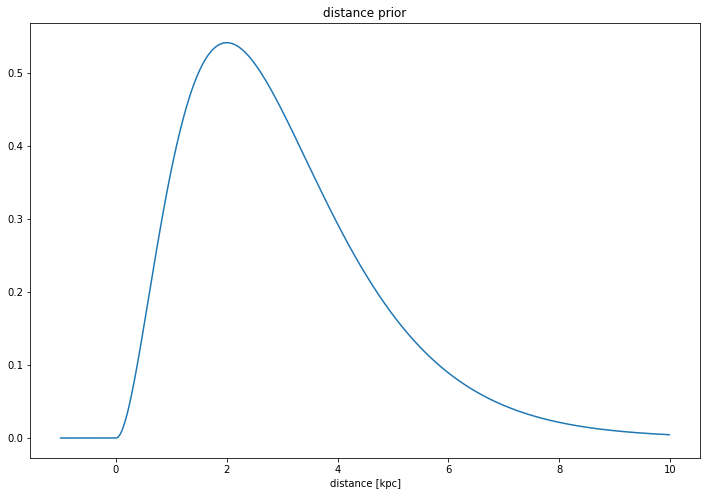

In [27]:
x =  np.arange(-1,10,0.01)
plt.plot(x,distPrior(x))
plt.title("distance prior")
plt.xlabel("distance [kpc]")

## posterior

In [28]:
def posterior(model,data):
    return likelihood(model,data) * distPrior(model)

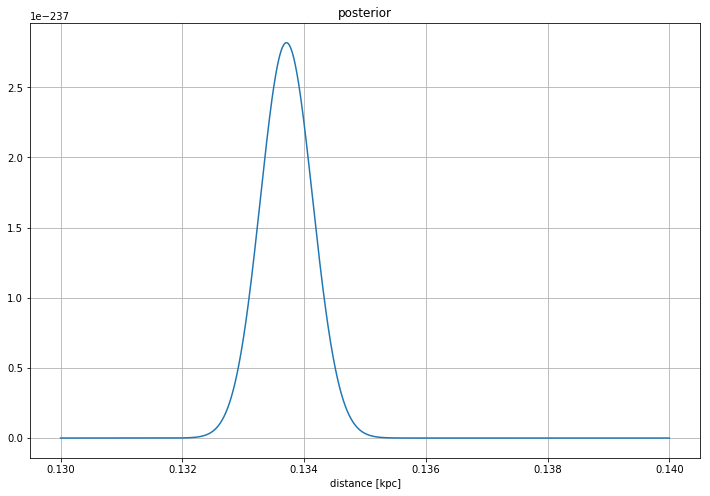

In [29]:
plt.plot(model,posterior(model,data))
plt.title("posterior")
plt.grid()
plt.xlabel("distance [kpc]")

## all in log scale

In [30]:
def log_likelihood(model,data) :
    """Return log10 (normalized) likelihood: P(3D astrometry | 3D phase space, Covariance)"""
    parallaxes, parallaxesCov = data
    pred = 1/parallaxes
    f = multivariate_normal(mean=pred, cov=parallaxesCov) 
    distances = model
    return f.pdflog(distances)

In [31]:
def log_prior(model):
    distances = model
    return np.log10(distPrior(distances))

In [32]:
def log_posterior(model,data) :
    logprior = log_prior(model)
    res = logprior + log_likelihood(model,data) if np.isfinite(logprior) else -np.inf
    return np.array(res)

# Study the effect of parallax correlation

 Return correlation coefficient between parallaxes for two
 sources with specified sky positions
 and amplitude amp (0-1) and length scale len (degrees)
 using an exponential correlation model.
 

 Note that this uses a simplified angular separation computation
 which does not work for large separations or near the poles.

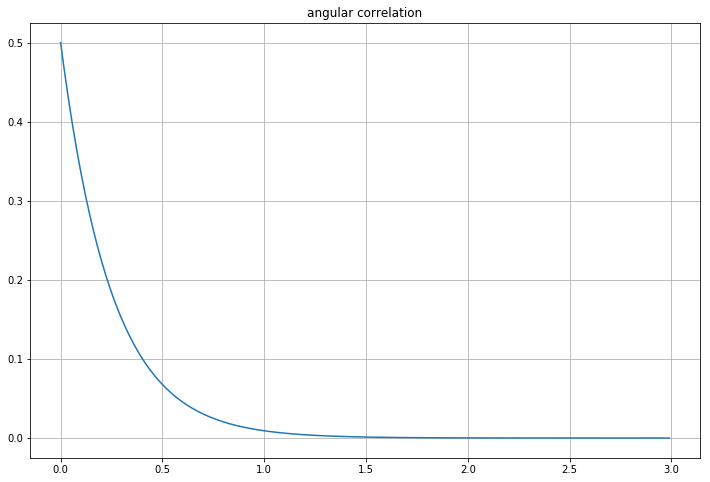

In [33]:
amp=0.5
l=0.25
x = np.arange(0,3,0.01)
y = amp*np.exp(-x/l)
plt.plot(x,y)
plt.grid()
plt.title("angular correlation")

In [34]:
def parallaxCorrelation(ra1, dec1, ra2, dec2, amp=0.5, l=0.25) :
    conv = np.pi/180 
    sep = np.sqrt(((ra1-ra2)*np.cos(conv*0.5*(dec1+dec2)))**2 + (dec1-dec2)**2)
    return( amp*np.exp(-sep/l))

def parallaxCovariance(d, amp=0.5, l=0.25) :
    n = len(d)
    V = np.matrix(np.zeros([n,n]))
    error = d.parallax_error.values
    ra = d.ra.values
    dec = d.dec.values
    for i in range(0,n) :
        for j in range(0,i) :
            V[i,j] = error[i]*error[j]*parallaxCorrelation(ra[i], dec[i], ra[j], dec[j],amp=amp,l=l)
            V[j,i] = V[i,j]
    return V + np.diag(d.parallax_error**2)

In [35]:
C = parallaxCovariance(d)

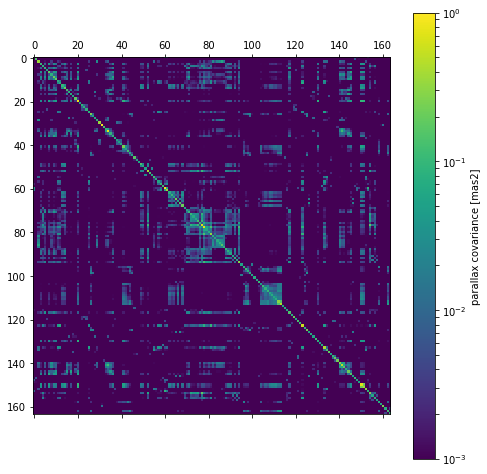

In [36]:
plt.matshow(C,norm=mp.colors.LogNorm(0.001,1))
plt.colorbar(label="parallax covariance [mas2]")

In [37]:
data = d.parallax, C

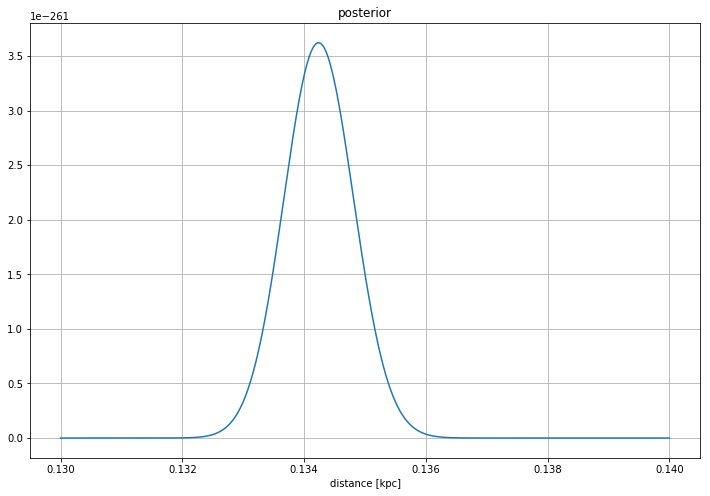

In [38]:
plt.plot(model,posterior(model,data))
plt.title("posterior")
plt.grid()
plt.xlabel("distance [kpc]")

# Infer cluster distance and size
Instead of assuming that all source is at the cluster center, we now consider the cluster internal dispertion.

We assume that the true stellar distances are drawn from a 3D isotropic Gaussian of mean rc and standard deviation sc.
* neglect parallax correlation
* **WARNING** : assuming that the cluster distribution in Gaussian is phase space is problematic. The inverse of a Gaussian is a bimodal distribution with no moments... see https://en.wikipedia.org/wiki/Inverse_distribution Remember that we do not want to inverse the Gaussian parallax error distribution.

## 1D assumption:
* Neglect cluster angular size, i.e. assume that all sources are along the line of sight. With this assumption, the true distances of the stars from the cluster center (z) are thus drawn from a 1D Gaussian with mean 0 and stdev sc.

### built simulated data
play with the numbers

In [39]:
rcTrue = 1 # true cluster distance
scTrue = 0.1 # true cluster spread
Nstar =  100 # number of star in the cluster (assume a perfect cluster membership selection)
rTrue = np.random.normal(rcTrue,scTrue,Nstar) # true distance of each star in the cluster
wsd = 0.3 *np.ones(Nstar) # uniform uncorrelated error measurement of the parallaxes
w = np.random.normal(1/rTrue,wsd,Nstar) # a realistation of the parallax measurement

In [40]:
d0 = pd.DataFrame()
d0["parallax"]=w
d0["parallax_error"]=wsd

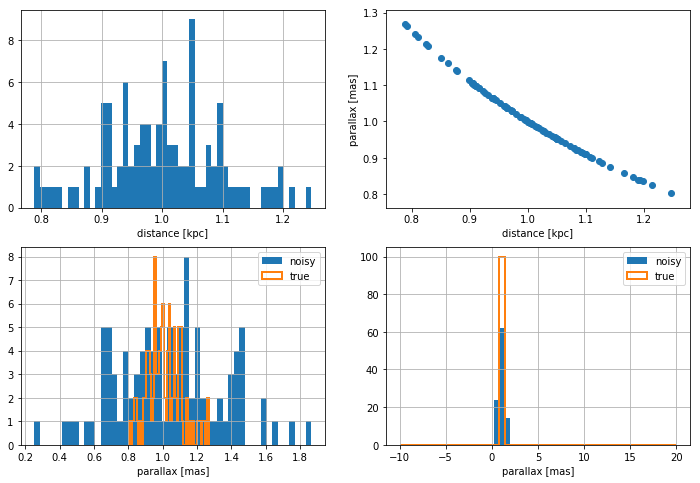

In [41]:
plt.subplot(221)
plt.hist(rTrue,bins=50)
plt.grid()
plt.xlabel("distance [kpc]")

plt.subplot(222)
plt.scatter(rTrue,1/rTrue)
plt.xlabel("distance [kpc]")
plt.ylabel("parallax [mas]")

plt.subplot(223)
d0.parallax.hist(bins=50,label="noisy")
plt.hist(1/rTrue,bins=50,histtype='step',lw=2,label="true");
plt.legend()
plt.xlabel("parallax [mas]")
plt.subplot(224)
r=(-10,20)
d0.parallax.hist(bins=50,label="noisy",range=r)
plt.hist(1/rTrue,bins=50,histtype='step',lw=2,label="true",range=r);
plt.legend()
plt.xlabel("parallax [mas]")

In [42]:
from scipy.stats import norm

### a strong and wrong simplification 
/!\ "the inverse of a Gaussian with sigma sc is Gaussian with dispersion sc"/!\

the likelihood is maximal for sc=0 !

In [43]:
n=100
rc = np.linspace(0.5, 1.5, n)
rc_test = np.outer(rc,np.ones(len(w)))
sc = np.logspace(0.0001, 1, n)

In [44]:
f = multivariate_normal(mean=w, cov=wsd**2+sc[0]**2*np.ones(len(w)))
f.logpdf(1/rc_test)

array([-146.25381959, -142.72434751, -139.46750786, -136.4601226 ,
       -133.68130416, -131.11219508, -128.73574118, -126.53649333,
       -124.5004339 , -122.61482447, -120.8680718 , -119.24960975,
       -117.74979488, -116.35981414, -115.07160295, -113.87777242,
       -112.77154458, -111.74669462, -110.79749929, -109.91869076,
       -109.10541524, -108.35319591, -107.65789949, -107.01570627,
       -106.42308301, -105.87675853, -105.3737016 , -104.91110099,
       -104.48634735, -104.09701674, -103.74085579, -103.41576805,
       -103.11980168, -102.85113817, -102.6080821 , -102.38905169,
       -102.19257029, -102.01725849, -101.86182692, -101.7250697 ,
       -101.60585832, -101.50313615, -101.41591325, -101.34326175,
       -101.28431144, -101.23824581, -101.20429839, -101.1817493 ,
       -101.16992211, -101.16818098, -101.17592793, -101.19260036,
       -101.21766874, -101.25063448, -101.29102793, -101.33840654,
       -101.39235317, -101.45247446, -101.51839937, -101.58977

In [45]:
dense=[]
for j in range(0,n) : 
    f = multivariate_normal(mean=w, cov=wsd**2+sc[j]**2*np.ones(len(w)))
    dense.append(f.logpdf(1/rc_test))
dense =  np.array(dense)

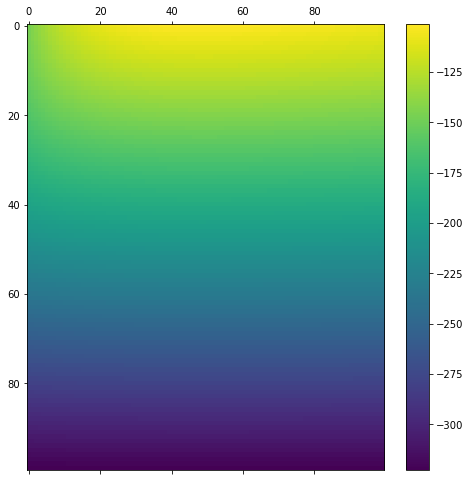

In [46]:
plt.matshow(dense,aspect="auto")
plt.colorbar()

### cluster size prior

In [47]:
from scipy.stats  import gamma

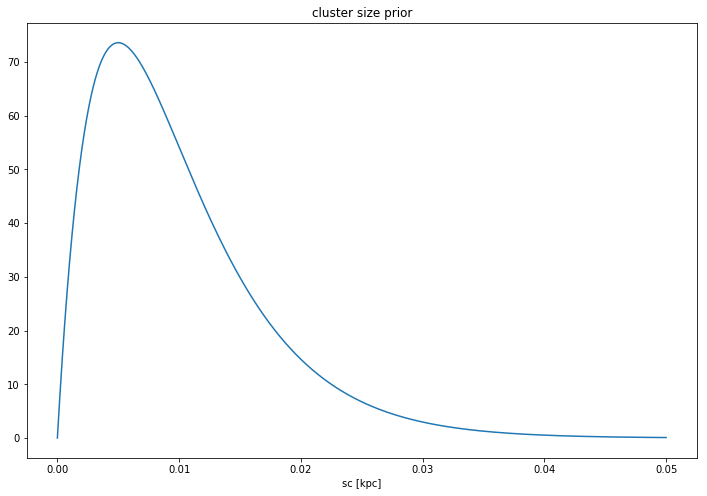

In [48]:
sc = np.linspace(0, 0.05,1000)
scPriorShape = 2
scPriorScale = 0.005
plt.plot(sc, gamma.pdf(sc, scPriorShape, scale=scPriorScale))
plt.xlabel("sc [kpc]")
plt.title("cluster size prior")

# A possible approach to estimate size and distance of cluster from parallaxes

* Bayes' rule
$$ P(r_c,s_c|W,C) = P(W|C,r_c,s_c)P(r_c,s_c)/P(W|C) $$ 
* Likelihood
$$ P(W|C,r_c,s_c) = \int P(W,R|C,r_c,s_c) dR $$
$$ P(W|C,r_c,s_c) = \int P(W|R,C) P(R|r_c,s_c) dR $$
    * where $ P(W|R,C) = N_n(W;\mu=1/R,\Sigma=C)$ is an n-dim normal
    * and $ P(R|r_c,s_c) = N_n(R;\mu=diag(r_c),\Sigma=diag(s_c^2))$ is the spherical Gaussian cluster model
    
* if one assumes that the parallaxes measurement are independent, i.e. $C = diag(\sigma_\varpi)$
    $$ P(W|C,r_c,s_c) = \int_R \Pi_i P_i dR = \Pi_i \int_{r_i} P_i dr_i $$

* Assume cluster distance $s_c$ known and let x be the distance to the cluster center, 
$$P(x|s_c)= N(0,s_c)$$

the true distance to a star is $r$ such that
$$ x^2 = r^2 + r_c^2 - 2 r r_c \cos \theta$$
where $\theta$ is known from the astrometry (it depends only on the position) unlike $r$  

$$ \int_{r_i} P_i dr_i = \int_{r=0}^{\infty} P(\varpi_i|r,\sigma_i) P(r|r_c,s_c,\theta_i) dr $$

where  
$$ P(\varpi_i|r,\sigma_i) = \frac{1}{\sigma_i \sqrt{2\pi}} \exp{-\frac{(\varpi_i-1/r)^2}{2 \sigma_i^2}} $$

Note :
* the integral defining the likelihood is a mixture of quadratic terms in $r$ and $1/r$ in the exponential, very unilikely to exist in a closed form expression (one should implement a numerical approximation of it).

* assuming $\cos \theta \sim 1$ (true for most of the clusters, except the Hyades) one get the 1D approximation
$$ P(r|r_c,s_c,\theta_i) = N(r;\mu=r_c,\sigma=s_c) $$

$$ \int_{r_i} P_i dr_i \sim \int_0^\infty \exp{-(\varpi_i-1/r)^2-(r-r_c)^2} dr $$

see also
* https://en.wikipedia.org/wiki/Student%27s_t-distribution
* https://arxiv.org/pdf/1511.05969.pdf

2